In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
np.random.seed(42)

from matplotlib import style
style.use('fivethirtyeight')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
os.chdir("/content/drive/MyDrive/road-signs-NN")

In [ ]:
# import os
# os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/road-signs-NN"

In [ ]:
# %cd /content/drive/MyDrive/road-signs-NN

/content/drive/MyDrive/road-signs-NN


In [ ]:
# !kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign --unzip

 99% 606M/612M [00:04<00:00, 160MB/s]
100% 612M/612M [00:04<00:00, 157MB/s]


In [ ]:
# %ls

kaggle.json  Meta/     test/  Test.csv  Train/     Untitled0.ipynb
meta/        Meta.csv  Test/  train/    Train.csv


In [3]:
train_path = '/content/drive/MyDrive/road-signs-NN/Train'
test_path = '/content/drive/MyDrive/road-signs-NN/Test'
meta_path = '/content/drive/MyDrive/road-signs-NN/Meta'

In [4]:
# SET PARAMS

# Resizing the images to 32x32x1
IMG_HEIGHT = 32
IMG_WIDTH = 32

# Total number of categories
NUM_CATEGORIES = len(os.listdir(train_path))
NUM_CATEGORIES

43

In [5]:
# Label Overview
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

In order to understand the distribution of the data, we have two helpful datasets in csv files.
Let's see how many pictures do we have in our datasets.

In [8]:
train_tabular = pd.read_csv('Train.csv')
test_tabular = pd.read_csv('Test.csv')

In [9]:
test_tabular.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png


In [10]:
train_df_desc = train_tabular.Path.apply(lambda x: x.split("/")[1])\
                             .value_counts()\
                             .to_frame()\
                             .reset_index()\
                             .rename({"index": "Index", "Path": "Cnt"}, axis=1)

train_df_desc["Class"] = pd.Series(classes)
train_df_desc["Index"].astype("int32")
train_df_desc["Index"].dtypes

dtype('O')

Ok, so we see that the highest number of signs is connected with speed limit signs.
Below we decided to show, two different signs. In the first case, the sign is quite obvious, so we assume, that our algorithm should not hvae any problem in recognising it. 
However, in the second example, on the first glance, it might be hard to estimate was sign is that.

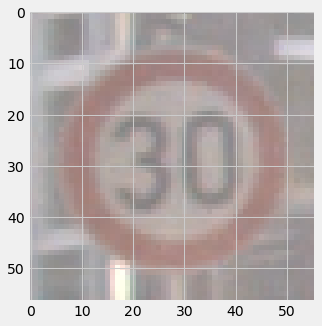

In [11]:
plt.figure(figsize=(10,5))
pic = Image.open(f'{train_path}/1/00001_00000_00000.png').convert('RGB')
plt.imshow(pic)

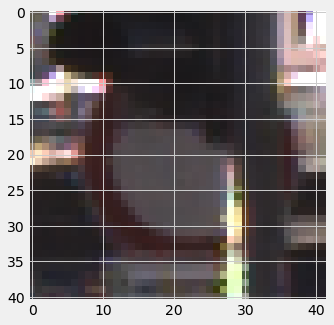

In [12]:
plt.figure(figsize=(10,5))
pic = Image.open(f'{train_path}/15/00015_00000_00000.png').convert('RGB')
plt.imshow(pic)

## Data preparation

In [13]:
train_df_desc[train_df_desc.Index == str(1)]["Cnt"]

1    2220
Name: Cnt, dtype: int64

In [ ]:
# Images rescaled to 32x32 resolution, all transformed to grayscale (single channel image)

In [14]:
# Retrieving the images and their labels 

images_list = []
labels = []

for i in range(NUM_CATEGORIES):
    path = os.path.join(train_path, str(i))
    images = os.listdir(path)

    for no_image in images:
        try:
            pic = Image.open(path + '/'+ no_image).convert('L')
            image = pic.resize((IMG_WIDTH, IMG_HEIGHT), Image.ANTIALIAS)
            pixels = np.array(image)
            image_ravel = pixels.ravel()
            images_list.append(image_ravel)
            labels.append(i)
        except:
            print("Error loading image")

    # Maximum number of same signs can't be higher than 2250      
    # if len(image_list) < 2250:
    #     print(f"Number of pictures of sign {no_image} is equal to = {train_df_desc[train_df_desc.Index == str({1})]["Cnt"]} which is correct")
    # else:
    #     print(f"Something is wrong with the {no_image} image")

# Converting lists into numpy arrays
images_list = np.array(images_list)
labels = np.array(labels)

In [15]:
# Check if everything is OK
print(images_list.shape, labels.shape)

(39209, 1024) (39209,)


#### Spliting into train/test

In [32]:
# Splitting training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(images_list, labels, test_size=0.2, random_state=42)

# Displaying the shape after the split
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# Converting the labels into one hot encoding
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)

(31367, 1024) (7842, 1024) (31367,) (7842,)


#### Frequency distribution

In [17]:
# train_distribution = pd.crosstab(index=train["label"],
#                                  columns="count")

# test_distribution = pd.crosstab(index=test["label"],
#                                 columns="count")

# fig, ax = plt.subplots(1,2, figsize=(15,7))
# train_distribution.plot.bar(ax=ax[0], title='Train', legend=False, cmap='PuBuGn_r')
# test_distribution.plot.bar(ax=ax[1], title='Test', legend=False)
# fig.show()


#### Preview the images



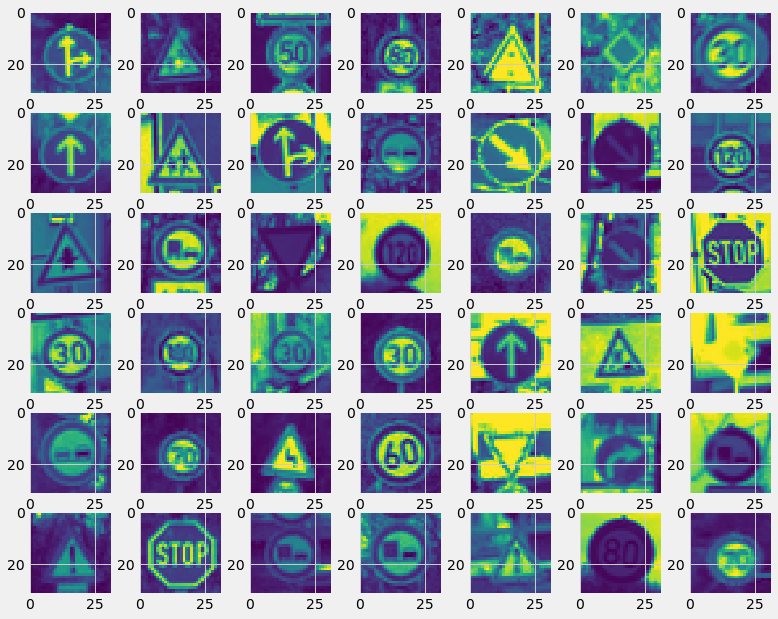

In [18]:
plt.figure(figsize=(12,10))
x, y = 7, 6
for i in range(42):  
    plt.subplot(y, x, i+1)
    plt.imshow(X_train[i].reshape((IMG_WIDTH, IMG_HEIGHT)), interpolation='nearest')
plt.show()

Successfully achieved 1 channel

#### Additional preparations

In [33]:
# Normalization to values between 0 an 1

X_train = X_train/255.0
X_test = X_test/255.0

In [34]:
# checking if all dimensions are correct

print('x_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

x_train shape: (31367, 1024)
31367 train samples
7842 test samples


In [35]:
# Reshaping

dim_to_reshape = X_train.shape[1]
X_train = X_train.reshape(X_train.shape[0], dim_to_reshape)
X_test = X_test.reshape(X_test.shape[0], dim_to_reshape)

In [36]:
print('x_train shape:', X_train.shape)
print('x_test shape:', X_test.shape)

x_train shape: (31367, 1024)
x_test shape: (7842, 1024)


## Random Forest

**NOTE** - It took us 90 minutes, to find the best params. We recommend to use pickled model.

In [24]:
# param_grid = [
# {'n_estimators': [50, 350], # The number of trees in the forest.
#  'max_features': [28, 50], # The number of features to consider when looking for the best split.
#  'max_depth': [10, 50]} # The maximum depth of the tree.
# ]

# grid_search_forest = GridSearchCV(RandomForestClassifier(), param_grid, cv=2, scoring='neg_mean_squared_error')
# grid_search_forest.fit(X_train, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
16 fits failed out of a total of 16.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
16 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py", line 327, in fit
    X, y = self._validate_data(
  File "/usr/local/lib/python3.8/dist-packages/sklearn/base.py", line 581, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/u

ValueError: ignored

In [26]:
import joblib
# joblib.dump(grid_search_forest.best_estimator_, 'random_forest_best_est.pkl')

In [40]:
loaded_rf_model = joblib.load('random_forest_best_est.pkl')
result = loaded_rf_model.score(X_test, y_test)
print(f'Random Forest accuracy: {100*np.round(result, 2)}%')

Random Forest accuracy: 88.0%


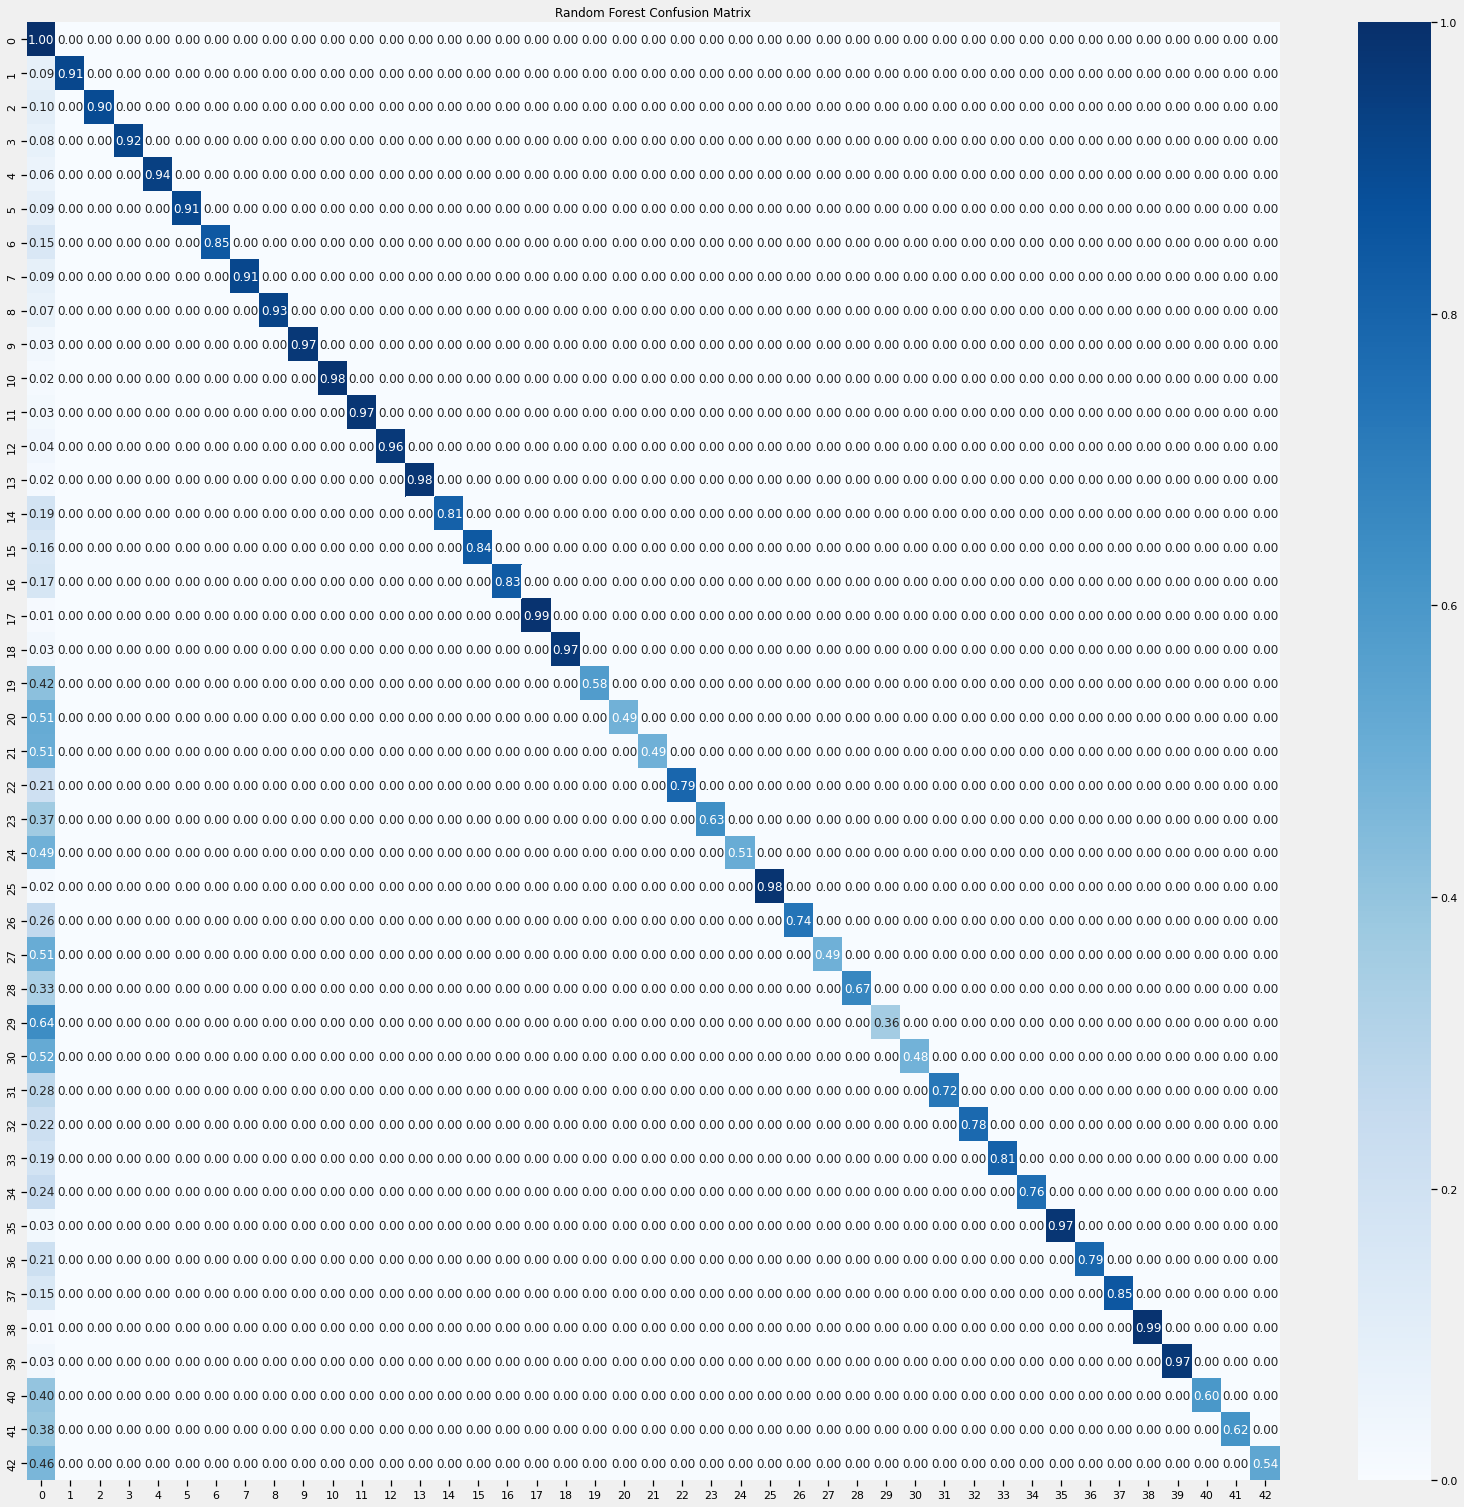

In [46]:
# Calculate predictions
import seaborn as sns
rf_predictions = loaded_rf_model.predict(X_test)
  
# creating a confusion matrix 
cm_rf = confusion_matrix(y_test.argmax(axis=1), rf_predictions.argmax(axis=1))
cm_rf = cm_rf.astype('float') / cm_rf.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(25,25))
sns.set_context("notebook")
sns.heatmap(cm_rf, annot = True, fmt='.2f', cmap="Blues").set_title("Random Forest Confusion Matrix")
plt.show()

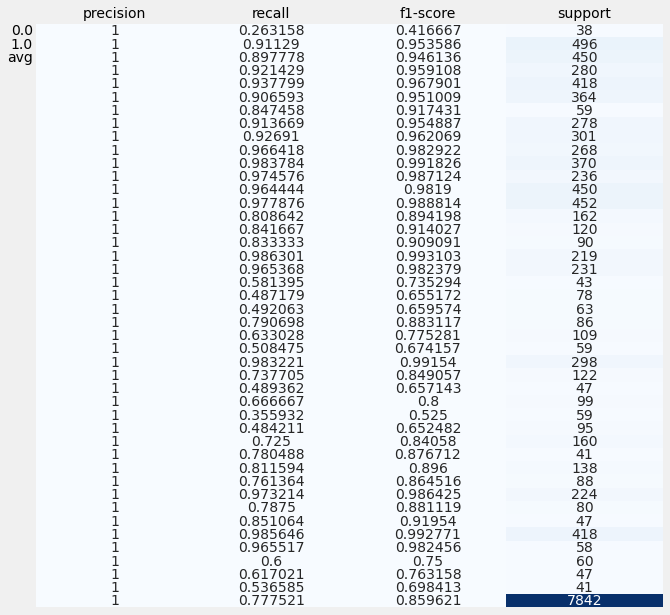

In [43]:
# utility function for plotting classification report
def plot_classification_report(y_tru, y_prd, figsize=(10, 10), ax=None):

    plt.figure(figsize=figsize)

    xticks = ['precision', 'recall', 'f1-score', 'support']
    yticks = list(np.unique(y_tru))
    yticks += ['avg']

    rep = np.array(precision_recall_fscore_support(y_tru, y_prd)).T
    avg = np.mean(rep, axis=0)
    avg[-1] = np.sum(rep[:, -1])
    rep = np.insert(rep, rep.shape[0], avg, axis=0)

    ax = sns.heatmap(rep,
                    annot=True, 
                    cbar=False, 
                    xticklabels=xticks, 
                    yticklabels=yticks,
                    ax=ax,
                    cmap="Blues",
                    fmt='g')
    ax.xaxis.set_ticks_position('top')


plot_classification_report(y_test, rf_predictions)

## Neural Networks - CNN

In [ ]:
# reshaping for cnn (keras requires input to be three-dimensional - in case of images with colours)

X_train = X_train.reshape(X_train.shape[0], 32, 32,1)
X_test = X_test.reshape(X_test.shape[0], 32, 32,1)

In [ ]:
from keras.models import Sequential, load_model
from keras.layers import Conv2D, Dense, Flatten, Rescaling, AveragePooling2D, Dropout

# Building the model
model = Sequential([
    Rescaling(1, input_shape=(32, 32, 1)),
    Conv2D(filters=6, kernel_size=(5, 5), activation='relu'),
    AveragePooling2D(pool_size=(2, 2)),
    Conv2D(filters=16, kernel_size=(5, 5), activation='relu'),
    AveragePooling2D(pool_size=(2, 2)),
    Conv2D(filters=120, kernel_size=(5, 5), activation='relu'),
    Dropout(0.2),
    Flatten(),
    Dense(units=120, activation='relu'),
    Dense(units=43, activation='softmax')
])

# Compilation of the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Model architecture
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 32, 32, 1)         0         
                                                                 
 conv2d_8 (Conv2D)           (None, 28, 28, 6)         156       
                                                                 
 average_pooling2d_2 (Averag  (None, 14, 14, 6)        0         
 ePooling2D)                                                     
                                                                 
 conv2d_9 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 average_pooling2d_3 (Averag  (None, 5, 5, 16)         0         
 ePooling2D)                                                     
                                                                 
 conv2d_10 (Conv2D)          (None, 1, 1, 120)        

In [ ]:
history = model.fit(X_train, y_train, epochs=50,
                    validation_data=(X_test, y_test))


Epoch 1/50
981/981 [==============================] - 28s 27ms/step - loss: 1.9199 - accuracy: 0.4584 - val_loss: 0.7146 - val_accuracy: 0.8058
Epoch 2/50
981/981 [==============================] - 27s 27ms/step - loss: 0.6987 - accuracy: 0.7856 - val_loss: 0.4581 - val_accuracy: 0.8659
Epoch 3/50
981/981 [==============================] - 29s 29ms/step - loss: 0.4801 - accuracy: 0.8565 - val_loss: 0.3270 - val_accuracy: 0.9056
Epoch 4/50
981/981 [==============================] - 23s 24ms/step - loss: 0.3669 - accuracy: 0.8888 - val_loss: 0.2461 - val_accuracy: 0.9281
Epoch 5/50
981/981 [==============================] - 24s 24ms/step - loss: 0.2958 - accuracy: 0.9103 - val_loss: 0.1707 - val_accuracy: 0.9560
Epoch 6/50
981/981 [==============================] - 24s 24ms/step - loss: 0.2452 - accuracy: 0.9289 - val_loss: 0.1406 - val_accuracy: 0.9662
Epoch 7/50
981/981 [==============================] - 24s 24ms/step - loss: 0.2056 - accuracy: 0.9381 - val_loss: 0.1211 - val_accuracy:

In [ ]:
val_loss, val_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nValifdation accuracy:', val_acc)
print('\nValidation loss:', val_loss)

246/246 - 6s - loss: 0.0466 - accuracy: 0.9904 - 6s/epoch - 24ms/step

Valifdation accuracy: 0.9904361367225647

Validation loss: 0.04658596217632294


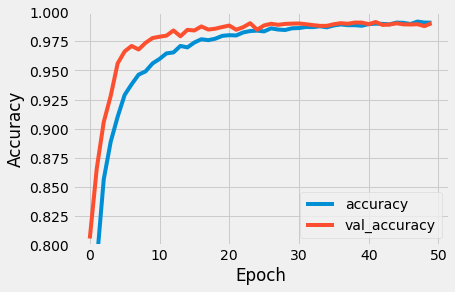

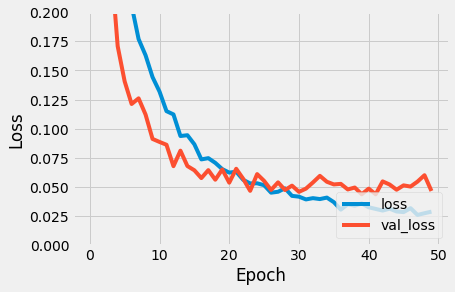

In [ ]:
plt.figure(0)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1])
plt.legend(loc='lower right')

plt.figure(1)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 0.2])
plt.legend(loc='lower right')

246/246 [==============================] - 3s 14ms/step


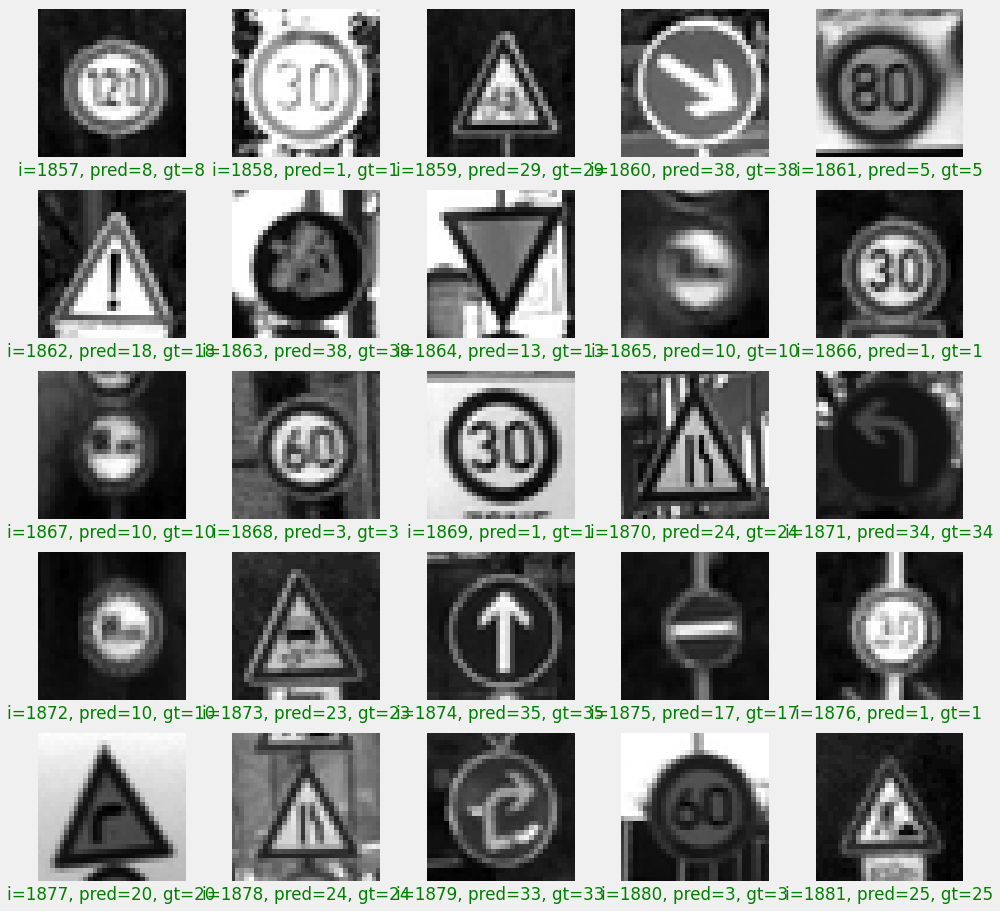

In [ ]:
import random
preds = model.predict(X_test)

plt.figure(figsize=(15, 15))
start_index = random.randint(0, 7800)
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    pred = np.argmax(preds[start_index+i])
    gt = np.argmax(y_test[start_index+i])
    
    col = 'g'
    if pred != gt:
        col = 'r'
    
    plt.xlabel('i={}, pred={}, gt={}'.format(start_index+i, pred, gt), color=col)
    plt.imshow(X_test[start_index+i].reshape((IMG_WIDTH, IMG_HEIGHT)), cmap='gray')
plt.show()